# New York City Sale Price Predictions
Predicting sale prices from the New York housing market 2016-2017 while looking at buildings valued between 10,000 USD and 1,000,000 USD.

# Introduction

In tandem with the surge of big data, machine learning (ML) is seeing an unprecedented growth in many fields. The increased processing-capacity of ML promotes the need for increased data collection to be able to take advantage of the ever-increasing complexity of ML algorithms (Polyzotis et al., 2018, p.). Furthermore, the capabilities of these expert systems are endless, and in many fields already outperform or perform on-par with experts (Roh et al., 2019; Simarjeet et al., 2020). The trove of information collected is often labeled as business intelligence, and then used to maximize profit, and minimize risk for stakeholders. Our hypothesis is that culminates in a somewhat skewed power-balance between consumers and businesses in terms of access to information. This report will therefore focus on equipping the average person with valuable insights in their purchase of property. 
 
A large part of the report will elaborate on the thought process in regards to the choice of data features to be included, and how it is processed. The reason being that if the process is viewed from an end-to-end perspective, the majority of the workload will be pre-processing of the data. Moreover, choosing correctly from the wide array of techniques is critical to achieve high accuracy, and preserve the integrity of the original data. To achieve this we will be looking at how different ML algorithms perform at predicting sale prices for different properties in New York city over a 12-month period. The time frame being from September 2016 to September 2017 using a dataset from Kaggle (City of New York, 2017). A test of three classification algorithms, namely k-nearest neighbour (k-NN), Multinomial Bayes (MNB), and a support vector machine (SVC) classifier will be conducted. In addition three regression algorithms will be tested, specifically linear regression (with and without L1/Lasso and L2/Ridge regularisation), as well as a random forest regressor. Moreover, the data-set will be tested on two neural networks, one classifier, and one regressive.


In [ ]:
# Libraries used: SKlearn, seaborn, Numpy, Pandas, Matplotlib

# Loading and reading the data
import pandas as pd
import numpy as np

df = pd.read_csv("nyc-rolling-sales.csv")

# Preparing the random state used for data splits
ran = 1
df

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84543,8409,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,34,,B9,37 QUAIL LANE,,10309,2,0,2,2400,2575,1998,1,B9,450000,2016-11-28 00:00:00
84544,8410,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,78,,B9,32 PHEASANT LANE,,10309,2,0,2,2498,2377,1998,1,B9,550000,2017-04-21 00:00:00
84545,8411,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7351,60,,B2,49 PITNEY AVENUE,,10309,2,0,2,4000,1496,1925,1,B2,460000,2017-07-05 00:00:00
84546,8412,5,WOODROW,22 STORE BUILDINGS,4,7100,28,,K6,2730 ARTHUR KILL ROAD,,10309,0,7,7,208033,64117,2001,4,K6,11693337,2016-12-21 00:00:00


# Data selection

In [ ]:
# Copy the data frame for inspection and converts objects and strings to ints
inspect_data = df.copy()
inspect_data = inspect_data.convert_dtypes()
inspect_data['LAND SQUARE FEET'] = pd.to_numeric(inspect_data['LAND SQUARE FEET'], errors = 'coerce')
inspect_data['GROSS SQUARE FEET'] = pd.to_numeric(inspect_data['GROSS SQUARE FEET'], errors = 'coerce')
inspect_data['SALE PRICE'] = pd.to_numeric(inspect_data['SALE PRICE'], errors = 'coerce')

In [ ]:
# Label encode the remaining string values so they will apppear in the heatmap
for column in inspect_data:
    if pd.api.types.is_string_dtype(inspect_data[column]) is True:
        inspect_data[column], uniques = pd.factorize(inspect_data[column])

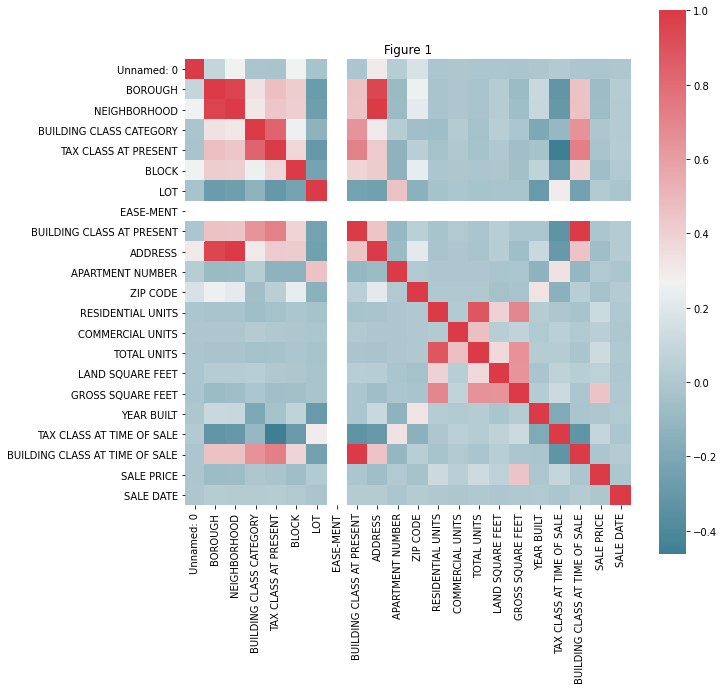

In [ ]:
# Heatmap (Figure 1)
import seaborn as sns
import matplotlib.pyplot as plt
corr = inspect_data.corr()
fig, ax = plt.subplots(figsize=(10,10)) 
plt.title('Figure 1')
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)

The data selection for our report was derived largely from trial and error with a goal of the highest possible accuracy. To confirm that these findings were in fact the best predictors, a heatmap using Seaborn was created to illustrate the correlation between the target value and the respective features (Figure 1). Approximately half of the features in the dataset were dropped (10/22). Some features were not relevant such as ‘Address’ and the unnamed feature numbering each row in the data, others showed a correlation that approximated null. The choice of ‘Sale price’ as the target data point was chosen because it was deemed to potentially produce the most meaningful data, and be practically useful for the target group. It can help the buyer more precisely understand the fluctuating prices as a result of the data features. A final list was concluded upon consisting of:

>'Sale price', 'Sale date', 'Borough', 'Gross square feet', 'Total units', 'Year built', 'Land square feet', 'Zip code', 'Tax class at time of sale', ‘Neighborhood’, 'Building class category'

The heat map (Figure 1) shows that the correlation is quite weak between the selected target ‘Sale price’ and features. A consequence which arises as a result of the weak correlation is an increased complexity of the ML algorithms as it is necessary to include more variables. Furthermore, as the feature count increases so does the need for pre-processing which in many cases causes a reduction of usable entries in the dataset.

# Preprocessing

In [ ]:
# Selecting the data we would like to use and prting it
data = df[['SALE PRICE', 'SALE DATE', 'BOROUGH', 'NEIGHBORHOOD', 'GROSS SQUARE FEET', 'TOTAL UNITS' ,'YEAR BUILT','LAND SQUARE FEET','ZIP CODE', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS CATEGORY']].copy()
data

,SALE PRICE,SALE DATE,BOROUGH,NEIGHBORHOOD,GROSS SQUARE FEET,TOTAL UNITS,YEAR BUILT,LAND SQUARE FEET,ZIP CODE,TAX CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY
0,6625000,2017-07-19 00:00:00,1,ALPHABET CITY,6440,5,1900,1633,10009,2,07 RENTALS - WALKUP APARTMENTS
1,-,2016-12-14 00:00:00,1,ALPHABET CITY,18690,31,1900,4616,10009,2,07 RENTALS - WALKUP APARTMENTS
2,-,2016-12-09 00:00:00,1,ALPHABET CITY,7803,17,1900,2212,10009,2,07 RENTALS - WALKUP APARTMENTS
3,3936272,2016-09-23 00:00:00,1,ALPHABET CITY,6794,10,1913,2272,10009,2,07 RENTALS - WALKUP APARTMENTS
4,8000000,2016-11-17 00:00:00,1,ALPHABET CITY,4615,6,1900,2369,10009,2,07 RENTALS - WALKUP APARTMENTS
...,...,...,...,...,...,...,...,...,...,...,...
84543,450000,2016-11-28 00:00:00,5,WOODROW,2575,2,1998,2400,10309,1,02 TWO FAMILY DWELLINGS
84544,550000,2017-04-21 00:00:00,5,WOODROW,2377,2,1998,2498,10309,1,02 TWO FAMILY DWELLINGS
84545,460000,2017-07-05 00:00:00,5,WOODROW,1496,2,1925,4000,10309,1,02 TWO FAMILY DWELLINGS
84546,11693337,2016-12-21 00:00:00,5,WOODROW,64117,7,2001,208033,10309,4,22 STORE BUILDINGS


In [ ]:
# Cheking the data types to see if anything needs to be changed
data.dtypes

SALE PRICE                   object
SALE DATE                    object
BOROUGH                       int64
NEIGHBORHOOD                 object
GROSS SQUARE FEET            object
TOTAL UNITS                   int64
YEAR BUILT                    int64
LAND SQUARE FEET             object
ZIP CODE                      int64
TAX CLASS AT TIME OF SALE     int64
BUILDING CLASS CATEGORY      object
dtype: object

In [ ]:
# Converts objects to string and integers
data = data.convert_dtypes()

In [ ]:
# Converts some integers formatted as strings into integers
data['LAND SQUARE FEET'] = pd.to_numeric(data['LAND SQUARE FEET'], errors = 'coerce')
data['GROSS SQUARE FEET'] = pd.to_numeric(data['GROSS SQUARE FEET'], errors = 'coerce')
data['SALE PRICE'] = pd.to_numeric(data['SALE PRICE'], errors = 'coerce')
data.dtypes

SALE PRICE                   float64
SALE DATE                     string
BOROUGH                        Int64
NEIGHBORHOOD                  string
GROSS SQUARE FEET            float64
TOTAL UNITS                    Int64
YEAR BUILT                     Int64
LAND SQUARE FEET             float64
ZIP CODE                       Int64
TAX CLASS AT TIME OF SALE      Int64
BUILDING CLASS CATEGORY       string
dtype: object

The median household income in New York was 61,937 USD in 2018, which meant that considering a building price of more than 1,000,000 USD was deemed unrealistic for the target group (Guzman, 2019, p. 2). Therefore, we proceeded to limit the scope of sale price to values between 10,000 USD and 1,000,000 USD to remove buildings sold at unrealistically low prices, as well as the unreasonably expensive outliers that skewed the data. There were 11,230 rows with a value below 100 USD, which was deemed to either be incorrect, or not a legitimate sale. This led to a total of 27,215 rows being dropped.

In [ ]:
# Removes sale prices below 1000 USD as we aren't intrested in looking at those, as well as the ones above 1000000 USD to remove the extreme outliers and set a scope
i = 0
to_remove = []
for cell in data['SALE PRICE']:
    if cell <= 10000 or cell > 1000000:
        to_remove.append(i)
    i+=1

data = data.drop(index=to_remove)
data

,SALE PRICE,SALE DATE,BOROUGH,NEIGHBORHOOD,GROSS SQUARE FEET,TOTAL UNITS,YEAR BUILT,LAND SQUARE FEET,ZIP CODE,TAX CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY
1,NaN,2016-12-14 00:00:00,1,ALPHABET CITY,18690.0,31,1900,4616.0,10009,2,07 RENTALS - WALKUP APARTMENTS
2,NaN,2016-12-09 00:00:00,1,ALPHABET CITY,7803.0,17,1900,2212.0,10009,2,07 RENTALS - WALKUP APARTMENTS
5,NaN,2017-07-20 00:00:00,1,ALPHABET CITY,9730.0,20,1900,2581.0,10009,2,07 RENTALS - WALKUP APARTMENTS
7,NaN,2017-07-20 00:00:00,1,ALPHABET CITY,21007.0,46,1900,5163.0,10009,2,07 RENTALS - WALKUP APARTMENTS
8,NaN,2017-06-20 00:00:00,1,ALPHABET CITY,9198.0,15,1920,1534.0,10009,2,08 RENTALS - ELEVATOR APARTMENTS
...,...,...,...,...,...,...,...,...,...,...,...
84542,NaN,2016-12-01 00:00:00,5,WOODROW,1800.0,2,1997,3020.0,10309,1,02 TWO FAMILY DWELLINGS
84543,450000.0,2016-11-28 00:00:00,5,WOODROW,2575.0,2,1998,2400.0,10309,1,02 TWO FAMILY DWELLINGS
84544,550000.0,2017-04-21 00:00:00,5,WOODROW,2377.0,2,1998,2498.0,10309,1,02 TWO FAMILY DWELLINGS
84545,460000.0,2017-07-05 00:00:00,5,WOODROW,1496.0,2,1925,4000.0,10309,1,02 TWO FAMILY DWELLINGS



Checking the data set for missing values revealed that 'Sale price' had 14,561 missing data points, which had to be dropped as a target value with a missing data point can not be predicted. 'Gross square feet' and 'Land square feet' also had 19,944 and 18,724 missing values respectively. As these were considered two important features a decision was made to drop the rows with missing values to assure as accurate predictions as possible. This led to a reduction in the dataset from 57,369 rows to 28,737 rows, almost halving the dataset. 


In [ ]:
# Converts empty values to NaN values and chekcs if there are any NaN values in our data
data.replace("", np.nan, inplace=True)
data.isnull().sum(axis = 0)

SALE PRICE                   14561
SALE DATE                        0
BOROUGH                          0
NEIGHBORHOOD                     0
GROSS SQUARE FEET            19944
TOTAL UNITS                      0
YEAR BUILT                       0
LAND SQUARE FEET             18724
ZIP CODE                         0
TAX CLASS AT TIME OF SALE        0
BUILDING CLASS CATEGORY          0
dtype: int64

In [ ]:
# Drops rows with empty values if there are any
data = data.dropna()
data.isnull().sum(axis = 0)

SALE PRICE                   0
SALE DATE                    0
BOROUGH                      0
NEIGHBORHOOD                 0
GROSS SQUARE FEET            0
TOTAL UNITS                  0
YEAR BUILT                   0
LAND SQUARE FEET             0
ZIP CODE                     0
TAX CLASS AT TIME OF SALE    0
BUILDING CLASS CATEGORY      0
dtype: int64

Most of the selected features were left intact, except 'Sale date' which was converted into 'Sale month' to potentially create a stronger correlation. As all the sale dates were formatted in the same way and label encoding would make it unusable; it was converted and split into months. In sequence the sale date column was dropped as sale month was deemed more meaningful.

In [ ]:
# Converts sale date to sale month, as the data only spans one year this could be a useful metric as prices fluctuate with time
dates = []
for date in data['SALE DATE']:
    dates.append(date[5:7])
data.insert(1,'SALE MONTH', dates)

data = data.drop( ['SALE DATE'], axis=1)
data['SALE MONTH'] = pd.to_numeric(data['SALE MONTH'], errors = 'coerce')
data

,SALE PRICE,SALE MONTH,BOROUGH,NEIGHBORHOOD,GROSS SQUARE FEET,TOTAL UNITS,YEAR BUILT,LAND SQUARE FEET,ZIP CODE,TAX CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY
223,416790.0,8,1,CHELSEA,6330.0,9,1901,1566.0,10011,2,07 RENTALS - WALKUP APARTMENTS
224,630370.0,8,1,CHELSEA,6330.0,9,1901,1566.0,10011,2,07 RENTALS - WALKUP APARTMENTS
277,282000.0,10,1,CHELSEA,12200.0,24,1850,4600.0,10011,2,09 COOPS - WALKUP APARTMENTS
2062,220000.0,12,1,FASHION,79465.0,15,1913,6994.0,10001,4,23 LOFT BUILDINGS
2587,489854.0,1,1,FLATIRON,30680.0,16,1900,4600.0,10003,2,08 RENTALS - ELEVATOR APARTMENTS
...,...,...,...,...,...,...,...,...,...,...,...
84541,648000.0,12,5,WOODROW,2160.0,2,1994,11088.0,10309,1,02 TWO FAMILY DWELLINGS
84543,450000.0,11,5,WOODROW,2575.0,2,1998,2400.0,10309,1,02 TWO FAMILY DWELLINGS
84544,550000.0,4,5,WOODROW,2377.0,2,1998,2498.0,10309,1,02 TWO FAMILY DWELLINGS
84545,460000.0,7,5,WOODROW,1496.0,2,1925,4000.0,10309,1,02 TWO FAMILY DWELLINGS


An attempt at dimension reduction on gross square feet and land square feet by multiplying the columns was made. However, the predictions resulted in slightly worse results of about 1% lower scores across the board. It was therefore decided to comment it out, but still conserve it in the code for potential further testing.

In [ ]:
# An attempt at feature reduction, gave abou 1% worse results in all our algorithms so we removed it
#data["TOTAL SQARE FEET"] = data["GROSS SQUARE FEET"] * data["LAND SQUARE FEET"]
#data = data.drop(["GROSS SQUARE FEET"], axis=1)
#data = data.drop(["LAND SQUARE FEET"], axis=1)

We proceed to factorize/label encode the remaining string values. In the final data set the only applicable feature is 'Neighbourhood'. However, the code is written to allow any remaining string values to be factorized as it was beneficial when testing different data frames and features. The reason was to make sure all the data is easy to understand for the respective algorithms. Besides integers perform much better than categorical data, which the classifiers do not accept as valid input.

In [ ]:
# Factorise / label encode reamaining string values turning each unique value into a number, currenly only applied to the Neighbourhood column and building class category
for column in data:
    if pd.api.types.is_string_dtype(data[column]) is True:
        data[column], uniques = pd.factorize(data[column])
data.dtypes

SALE PRICE                   float64
SALE MONTH                     int64
BOROUGH                        Int64
NEIGHBORHOOD                   int64
GROSS SQUARE FEET            float64
TOTAL UNITS                    Int64
YEAR BUILT                     Int64
LAND SQUARE FEET             float64
ZIP CODE                       Int64
TAX CLASS AT TIME OF SALE      Int64
BUILDING CLASS CATEGORY        int64
dtype: object

The final part of the general pre-processing consisted of one-hot encoding borough, this was done to ensure the algorithms understood the unique boroughs were different entities and avoiding the misinterpretation that borough 1<5. We also dropped the first column to avoid issues with the dummy variable trap which would have ingested multicollinearity into the dataset. As it would cause the respective features to correlate with each other (Matho 2019).

In [ ]:
# One-hot encodes borough, we also make sure to drop the first column to account for multicollinearity and the dummy variable trap
borough = pd.get_dummies(data['BOROUGH'], prefix='BOROUGH', drop_first=True)
borough
data = data.drop( ['BOROUGH'], axis=1)
data = data.join(borough)
data

,SALE PRICE,SALE MONTH,NEIGHBORHOOD,GROSS SQUARE FEET,TOTAL UNITS,YEAR BUILT,LAND SQUARE FEET,ZIP CODE,TAX CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5
223,416790.0,8,0,6330.0,9,1901,1566.0,10011,2,0,0,0,0,0
224,630370.0,8,0,6330.0,9,1901,1566.0,10011,2,0,0,0,0,0
277,282000.0,10,0,12200.0,24,1850,4600.0,10011,2,1,0,0,0,0
2062,220000.0,12,1,79465.0,15,1913,6994.0,10001,4,2,0,0,0,0
2587,489854.0,1,2,30680.0,16,1900,4600.0,10003,2,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84541,648000.0,12,227,2160.0,2,1994,11088.0,10309,1,5,0,0,0,1
84543,450000.0,11,227,2575.0,2,1998,2400.0,10309,1,5,0,0,0,1
84544,550000.0,4,227,2377.0,2,1998,2498.0,10309,1,5,0,0,0,1
84545,460000.0,7,227,1496.0,2,1925,4000.0,10309,1,5,0,0,0,1


# Data inspection

To further inspect the data, we created a second correlation heatmap to check if the preprocessing affected the correlation between ‘Sale price’ and the features. The heatmap revealed that the addition of ‘Sale month’ had no effect and the correlation between sale price and gross square feet is reduced after dropping the NaN values and the data above 1,000,000. Tests were conducted which found that the consequences of dropping these aforementioned values were that the classifiers perform worse. However, the regressors gain some performance when the values above 1,000,000 were removed. Therefore, some accuracy was sacrificed either way. It was decided to remove these values as it helps limit the scope and get a better picture of the housing market for the average consumer. The gain in the classifiers accuracy with the ‘Sale price’ above 1,000,000 included  might be due to how the percentiles were split.

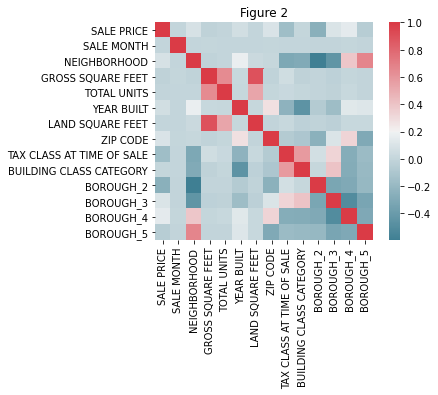

In [ ]:
# Heatmap (Figure 2)
corr = data.corr()
plt.title('Figure 2')
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)

# Classifier preprocessing

To best evaluate the algorithms a few criteria and metrics will be used. For the classifiers accuracy is utilised to measure the success, and for the regressive methods R2 coefficient illustrates how close the data is to the fitted line. In addition, cross-validation will be applied to ensure the validity of the results and ensure that the train/test split is not enforcing a bias. Moreover, k-fold will be applied to the cross-validation to prevent negative scores.


We made the decision to use the same features on all the algorithms, as it would make for a more meaningful comparison. However, some specific changes to the classifier and the regressive methods were made. To make sure that the data could be classified correctly by the classifiers it was decided to round the target data to percentiles, which was only done for the classifiers. We opted on using every fifth percentile which resulted in a total of 21 different values for the classification, including the first percentile. The trade off is that the predictions won’t be as accurate, but will instead get an estimate of price range. Which will be helpful to the average house buyer to ascertain if a house is priced reasonably or not. It was concluded that the fifth percentile was a good balance between different price representations and the total accuracy of the predictions we aimed to achieve. In addition, the data was scaled using the minMax scaler.


In [ ]:
# Rounds off the target data into 21 closest percentiles for the classifiers
percentiles=[]
for i in range(0,101, 5):
    percentiles.append(np.percentile(data['SALE PRICE'], i).round())
prices=[]
for price in data['SALE PRICE']:
    prices.append(np.array(percentiles).flat[np.abs(np.array(percentiles) - price).argmin()])
classifier_data = data.copy()
classifier_data['SALE PRICE'] = prices
classifier_data

,SALE PRICE,SALE MONTH,NEIGHBORHOOD,GROSS SQUARE FEET,TOTAL UNITS,YEAR BUILT,LAND SQUARE FEET,ZIP CODE,TAX CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5
223,425000.0,8,0,6330.0,9,1901,1566.0,10011,2,0,0,0,0,0
224,625000.0,8,0,6330.0,9,1901,1566.0,10011,2,0,0,0,0,0
277,265000.0,10,0,12200.0,24,1850,4600.0,10011,2,1,0,0,0,0
2062,202800.0,12,1,79465.0,15,1913,6994.0,10001,4,2,0,0,0,0
2587,485000.0,1,2,30680.0,16,1900,4600.0,10003,2,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84541,665000.0,12,227,2160.0,2,1994,11088.0,10309,1,5,0,0,0,1
84543,455000.0,11,227,2575.0,2,1998,2400.0,10309,1,5,0,0,0,1
84544,550000.0,4,227,2377.0,2,1998,2498.0,10309,1,5,0,0,0,1
84545,455000.0,7,227,1496.0,2,1925,4000.0,10309,1,5,0,0,0,1


In [ ]:
# The list of the percentiles "Sale price" has been split into
percentiles

[10001.0,
 135000.0,
 202800.0,
 265000.0,
 312500.0,
 350000.0,
 391168.0,
 425000.0,
 455000.0,
 485000.0,
 515000.0,
 550000.0,
 585493.0,
 625000.0,
 665000.0,
 710000.0,
 755000.0,
 810000.0,
 875000.0,
 950000.0,
 1000000.0]

In [ ]:
# Scales and splits the data into training and test sets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
x = classifier_data.drop(['SALE PRICE'], axis=1)
x_scale = scaler.fit_transform(x)
y = classifier_data['SALE PRICE']
X_train, X_test, y_train, y_test = train_test_split(x_scale, y, random_state=ran)

# k-NN

The k-NN algorithm is one of the more popular classifier methods, famed for its low error rate and ease of use (Kuang & Zhao, 2009, p. 151).

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#Sets up Kfold for all cross validation
kf = KFold(shuffle=True, n_splits=5)

#Grid search for the neighbours, weight and metric which gives the best score on our test data
best_score = 0
for neighbors in range(1,11):
    for weight in ['uniform', 'distance']:
      for metric in ['minkowski',  'manhattan', 'euclidean']:
        knn_clf = KNeighborsClassifier(n_neighbors=neighbors, weights=weight, metric=metric)
        knn_clf.fit(X_train, y_train)
        score = knn_clf.score(X_test, y_test)
        if score > best_score:
            best_score = score
            best_parameters = {'neighbors': neighbors, 'weight': weight, 'metric': metric}

knn_clf = KNeighborsClassifier(n_neighbors=best_parameters['neighbors'], weights=best_parameters['weight'], metric=best_parameters['metric'])
knn_clf.fit(X_train, y_train)
cross_val_scores = cross_val_score(knn_clf, x_scale, y, cv= kf)

print("Best parameters: {}".format(best_parameters)) #{'neighbors': 8, 'weight': 'distance', 'metric': 'manhattan'}
print(f'training set accuracy: {knn_clf.score(X_train, y_train)}')
print(f'Test set accuracy: {knn_clf.score(X_test, y_test)}')
print('Cross-validation scores: {}'.format(cross_val_scores))

Best parameters: {'neighbors': 6, 'weight': 'distance', 'metric': 'manhattan'}
training set accuracy: 0.9506774313288789
Test set accuracy: 0.13556019485038273
Cross-validation scores: [0.13013222 0.13674322 0.13259092 0.12806682 0.14059509]


k-NN originally had a test accuracy of ~0.12, but after the addition of one-hot encoding showed a 0.02 increase. Grid-search was used to find the best parameters which was the amount of neighbours, weight and metric. It is clear that the model overfits heavily as the training accuracy is 0.95. The addition of one-hot encoding added to the complexity of the data set, which could be an influencing factor as to the cause of overfitting. 



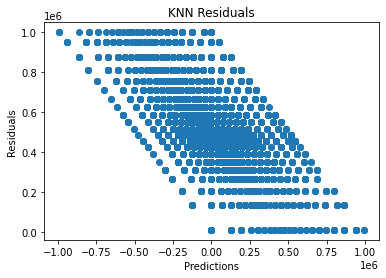

In [ ]:
# Residual plot from our k-NN predictions
pred = knn_clf.predict(X_test)
residuals = y_test-pred
plt.scatter(residuals, pred)
plt.ylabel('Residuals')
plt.xlabel('Predictions')
plt.title('KNN Residuals')
plt.show()

# Bayes

Multinomial Naive Bayes (MNB) is a probabilistic learning classifier that is easily trained and calculates probability based on the bayes’ theorem (Bonaccorso, 2017).

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Finds the best alpha fro Bayes
best_score = 0
for alpha in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    bay_clf = MultinomialNB(alpha=alpha)
    bay_clf.fit(X_train, y_train)
    score = bay_clf.score(X_test, y_test)
    if score > best_score:
            best_score = score
            best_alpha = alpha

bay_clf =MultinomialNB(alpha=best_alpha)
bay_clf.fit(X_train, y_train)
cross_val_scores = cross_val_score(bay_clf, x_scale, y, cv= kf)

print("Best alpha: ", best_alpha)
print(f'Training set prediction: {bay_clf.score(X_train,y_train)}')
print(f'Test set accuracy: {bay_clf.score(X_test, y_test)}')
print('Cross-validation scores: {}'.format(cross_val_scores))

Best alpha:  1000
Training set prediction: 0.09177802524127691
Test set accuracy: 0.10173973556019485
Cross-validation scores: [0.09116214 0.08698678 0.09622412 0.08821994 0.0819558 ]


The MNB algorithm reported a training set score of 0.09 and a test set accuracy of 0.10. MNB is based on a naive assumption which implies the conditional independence of causes. It also means that each feature contributes independently regardless of correlation which could be a factor that contributes to the low accuracy score (Bonaccorso, 2017). Moreover, MNB is commonly used for document classification using the bag of words model where it disregards all but multiplicity. In this use case some features such as ‘Square feet’ have many unique variables, making it hard for the algorithm to make meaningful predictions. It raises the question of the feasibility of MNB on the dataset as manipulating it further can cause the data to lose its original value. The other option is to create a new collection of features to be used only by MNB, yet this would make it unusable in terms of comparison with the other ML models. 

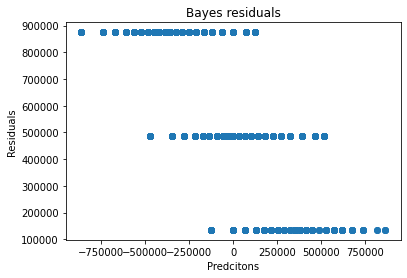

In [ ]:
# Residual plot from our Bayes predictions
pred = bay_clf.predict(X_test)
residuals = y_test-pred
plt.scatter(residuals, pred)
plt.ylabel('Residuals')
plt.xlabel('Predcitons')
plt.title('Bayes residuals')
plt.show()

# SVC

A support vector machine is an ML algorithm that used for both classification and regression tasks, in our project we applied it as a classification algorithm. SVM’s are highly preferred by many as they produce significant accuracy with less computation power (Gandhi, 2018).


In [ ]:
# Warning! Takes about 50 minutes in Google Colab. To avoid running the entire grid search use 'C': 100, 'gamma': 10 as the parameters.
from sklearn.svm import SVC

#Grid search for finding the best gamma and C. The code has been lifted and modified from lecture 10, slide 29 (SOURCE)
best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svc = SVC(gamma=gamma, C=C)
        svc.fit(X_train, y_train)
        score = svc.score(X_test, y_test)
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

svc = SVC(gamma=best_parameters['gamma'], C=best_parameters['C'])
#To minimize runtime comment out the grid search above and remove the comment below. Should reduce runtime to 5 minutes
#svc = SVC(gamma=10], C=100)
svc.fit(X_train, y_train)
cross_val_scores = cross_val_score(svc, x_scale, y, cv= kf)

print("Best parameters: {}".format(best_parameters))
print(f'Training set accuracy: {svc.score(X_train, y_train)}')
print(f'Test set accuracy: {svc.score(X_test, y_test)}')
print('Cross-validation scores: {}'.format(cross_val_scores))

Best parameters: {'C': 100, 'gamma': 10}
Training set accuracy: 0.20638455827765403
Test set accuracy: 0.12498260264439805
Cross-validation scores: [0.12439109 0.11725818 0.11988864 0.12945885 0.12667479]


For the SVC a simple grid search was implemented in an attempt to find the best alpha and gamma values. It caused a drastic run-time increase but facilitated a better fit for the dataset in correspondence to the model. It resulted in an accuracy of ~0.12 on the test data and ~0.20 on the training data.

Three different classifier algorithms were performed on the data set, yielding three different results. To be able to compare the classifier algorithms it was decided to use equivalent methods for the preprocessing of data. The kNN method was used to establish a baseline, but came with the issue of overfitting. The baseline persisted through the testing, as the classifier with the highest accuracy. It was hypothesised that SVC would surpass kNN in terms of accuracy, but as SVC is generally hard to inspect and ascertain the reason for its predictions, the cause remains unknown. Nonetheless, the low accuracy implies that classifiers are not the best models for the specific target value.

# Regression preprocessing

Classification algorithms do not appear to be the way to solve this challenge. Therefore, a more appropriate way to tackle this challenge would be using regressive algorithms without splitting the target values into percentiles. For regression, different scalers were applied, to ensure the most appropriate method was used. We tested the minMax, Standard, Max Abs, Robust, Quantile transformer, and last Power transformer Scalers. In the end, the power transformer scaler was elected, which makes the data more Gaussian-like. Due to the number of outliers and data variation in the data set it was deemed a good fit. It also provided the best results after testing multiple scalers with the trial and error method.


In [ ]:
# Sets up and scales the data to be more suitable for regression
reggression_data = data.copy()
# scaler = preprocessing.MinMaxScaler()
# scaler = preprocessing.StandardScaler()
# scaler = preprocessing.MaxAbsScaler()
# scaler = preprocessing.RobustScaler()
# scaler = preprocessing.QuantileTransformer()
scaler = preprocessing.PowerTransformer()

x = reggression_data.drop(['SALE PRICE'], axis=1)
x_scale = scaler.fit_transform(x)
y = reggression_data['SALE PRICE']
X_train, X_test, y_train, y_test = train_test_split(x_scale, y, random_state=ran)

# Linear regression

We chose to take advantage of linear regression for this dataset. This algorithm is very good in terms of speed, but not the best when it comes to accuracy. We also tried to see if using lasso and ridge regularisation would indicate any change in the results.

In [ ]:
# Linear regression without any regularisation
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score

linreg = LinearRegression()
linreg.fit(X_train, y_train)
cross_val_scores = cross_val_score(linreg, x_scale, y, cv= kf)

print(f'Training set R2 Coefficient: {r2_score(y_train, linreg.predict(X_train))}')
print(f'Test set R2 Coefficient:: {r2_score(y_test, linreg.predict(X_test))}')
print('Cross-validation scores: {}'.format(cross_val_scores))

Training set R2 Coefficient: 0.17248854112874867
Test set R2 Coefficient:: 0.19519771500553174
Cross-validation scores: [0.17498478 0.16809012 0.16444821 0.18484415 0.19294267]


In [ ]:
# Linear regression with L1/Lasso regularisation, takes about a minute due to number of iterations and cross validation.
from sklearn.linear_model import Lasso
lasso = Lasso(max_iter=100000)
lasso.fit(X_train, y_train)
cross_val_scores = cross_val_score(lasso, x_scale, y, cv= kf)

print(f'Training set R2 Coefficient: {r2_score(y_train, lasso.predict(X_train))}')
print(f'Test set R2 Coefficient:: {r2_score(y_test, lasso.predict(X_test))}')
print('Cross-validation scores: {}'.format(cross_val_scores))

Training set R2 Coefficient: 0.17248851833389478
Test set R2 Coefficient:: 0.19519300706008558
Cross-validation scores: [0.18681067 0.1867303  0.1741897  0.15849094 0.17838061]


In [ ]:
#Linear regression with L2/Ridge regularization
from sklearn.linear_model import Ridge

#Finds the best alpha
best_score = 0
for alpha in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    ridge = Ridge(alpha=alpha, normalize=True)
    ridge.fit(X_train, y_train)
    score = ridge.score(X_test, y_test)
    if score > best_score:
            best_score = score
            best_alpha = alpha

ridge = Ridge(alpha=best_alpha, normalize=True)
ridge.fit(X_train, y_train)
cross_val_scores = cross_val_score(ridge, x_scale, y, cv= kf)

print("Best alpha: ", best_alpha)
print(f'Training set R2 Coefficient: {r2_score(y_train, ridge.predict(X_train))}')
print(f'Test set R2 Coefficient:: {r2_score(y_test, ridge.predict(X_test))}')
print('Cross-validation scores: {}'.format(cross_val_scores))

Best alpha:  0.001
Training set R2 Coefficient: 0.17176516402149522
Test set R2 Coefficient:: 0.19377524582225725
Cross-validation scores: [0.17562655 0.18258954 0.17770414 0.17039556 0.17536457]


The R2 score for linear regression without any kind of regularisation is 0.17 on the training set and 0.19 on the test set. None of the results change significantly when applying lasso and ridge regularisation. Their equal performance is due to the amount of training data (Müller & Guido. 2016. p. 53).

# Random forest regressor

Random forest regression is very powerful, and works well without heavy tuning of the parameters (Müller & Guido. 2016. p. 87). It is a more complex model than linear regression, and is therefore slower,  more accurate. Additionally, it combats the overfitting issue that the decision tree algorithm brings with it, as it averages the overfitting of many differently configured decision trees, hence the name forest (Müller & Guido. 2016. p. 83).

In [ ]:
# Random forest regressor
from sklearn.ensemble import RandomForestRegressor
rf_regr = RandomForestRegressor()
rf_regr.fit(X_train, y_train)
cross_val_scores = cross_val_score(rf_regr, x_scale, y, cv= kf)

print(f'Training set R2 Coefficient: {r2_score(y_train, rf_regr.predict(X_train))}')
print(f'Test set R2 Coefficient:: {r2_score(y_test, rf_regr.predict(X_test))}')
print('Cross-validation scores: {}'.format(cross_val_scores))

Training set R2 Coefficient: 0.9202822432173919
Test set R2 Coefficient:: 0.5395650758666148
Cross-validation scores: [0.5199049  0.51133324 0.52745925 0.53785241 0.52693197]


This algorithm shows superior performance on this data with an R2 coefficient of 0.53 on the test data. Although, when taking the training score of 0.92 into consideration, it is clear that this model is overfitting to some degree. The cross-validation scores back up our test set score with an average of ~0.52.


Four regression algorithms were tested on the dataset. All three linear regression-based models produced remarkably similar scores. Conversely the random forest regressor produced much higher results, albeit with overfitting. In spite of this, the much higher test score of the random forest regressor makes it the most appropriate model for this dataset.

# Neural network preprocessing - classifier

Two neural networks were also fashioned. The first being a classifier that runs on the same dataset as k-NN, Bayes and SVC without any other tweaks to the data and is also scaled using the MinMax scaler. 

In [ ]:
# A classifier that runs on the same data as kNN, Bayes and SVC
scaler = preprocessing.MinMaxScaler()
x = classifier_data.drop(['SALE PRICE'], axis=1)
x_scale = scaler.fit_transform(x)
y = classifier_data['SALE PRICE']
X_train, X_test, y_train, y_test = train_test_split(x_scale, y, random_state=ran)

# Neural network - classifier

The classification neural network has two hidden layers consisting of 16 and 12 nodes respectively. It uses tanh as an activation function and adam as its solver. The alpha is found dynamically through grid search.

In [ ]:
# The classifier takes about 10 minutes to run
from sklearn.neural_network import MLPClassifier

# Finds the best alpha
best_score = 0
for alpha in [0.0001, 0.001, 0.01, 0.1, 0.5, 1]:
    nn = MLPClassifier(hidden_layer_sizes = [16, 12], activation = 'tanh', alpha = alpha, solver = 'adam',  max_iter=10000)
    nn.fit(X_train, y_train)
    score = nn.score(X_test, y_test)
    if score > best_score:
            best_score = score
            best_alpha = alpha

nn = MLPClassifier(hidden_layer_sizes = [16, 12], activation = 'tanh', alpha = best_alpha, solver = 'adam',  max_iter=10000)
nn.fit(X_train,y_train)
cross_val_scores = cross_val_score(nn, x_scale, y, cv= kf)

print("Best alpha: ", best_alpha)
print("Train  accuracy ", nn.score(X_train, y_train))
print("Test accuracy ",  nn.score(X_test, y_test))
print('Cross-validation scores: {}'.format(cross_val_scores))

Best alpha:  0.001
Train  accuracy  0.12583518930957685
Test accuracy  0.1269311064718163
Cross-validation scores: [0.1270007  0.1203897  0.12058465 0.12041065 0.11954063]


Text(0.5, 1.0, 'NN Loss curve')

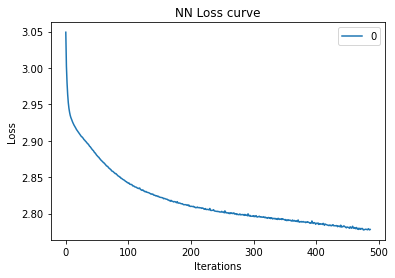

In [ ]:
# Loss curve for our NN
pd.DataFrame(nn.loss_curve_).plot()
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.title('NN Loss curve')

The classifier NN performs on-par with the best of the classifier model, namely SVC. Nonetheless, it retains the low accuracy found across all of the classifiers. The NN loss curve graph indicates a logarithmic distribution, and hence more iteration will not result in significant reduction in loss. It reinforces the notion that classifiers are less suited than the regressors for this task.

# Neural network preprocessing - regressive

The other neural network is a regressive neural network which runs on it’s own data, This time scaled using the standard scaler as it was found to give better results.

In [ ]:
# Scales and splits into training data and test
scaler = preprocessing.StandardScaler()
reg_nn_data = data.copy()
x = reg_nn_data.drop(['SALE PRICE'], axis=1)
y = reg_nn_data['SALE PRICE']
x_scale = scaler.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(x_scale, y, random_state=ran)

# Neural network - regressive

The regressive neural network also consists of two layers, this time featuring 8 and 4 nodes each. Takes advantage of relu as it’s activation function, and has a set alpha of 0.001. We applied lbfgs as our solver and have a learning rate of 0.01.

In [ ]:
# Runs the regresive Neural network. Takes a couple of minutes to run
from sklearn.neural_network import MLPRegressor

reg_nn = MLPRegressor(hidden_layer_sizes = (8, 4), activation = 'relu', alpha=0.001,  solver = 'lbfgs', max_iter=10000, learning_rate_init=0.01, random_state=ran)
reg_nn.fit(X_train,y_train)
cross_val_scores = cross_val_score(reg_nn, x_scale, y, cv= kf)

print(f'Training set R2 Coefficient: {r2_score(y_train, reg_nn.predict(X_train))}')
print(f'Test set R2 Coefficient:: {r2_score(y_test, reg_nn.predict(X_test))}')
print('Cross-validation scores: {}'.format(cross_val_scores))

Training set R2 Coefficient: 0.30870401933522595
Test set R2 Coefficient:: 0.31635352399544003
Cross-validation scores: [-0.18533392  0.24016407  0.08669366  0.35771128  0.39543767]


The regressive NN performs better than all other regressors with the exception of random forest, but does so without overfitting. The variation of the cross-validation scores are substantial, and it is speculated that it is a result of the significant variance within the dataset itself. In turn causing different splits of the validation set to vary greatly. Moreover, it is difficult to establish the learning curve as the solver 'L-BFGS' does not track loss during training. 

# Insights

Early on it was concluded that an increase in features does not necessarily result in better accuracy, and could in some cases worsen it. The reason being that an increase in features often leads to a substantial reduction in the dataset. Herein a missing value in just one of the cell’s rows would culminate in removing the row entirely. The challenge then becomes finding a balance so as to not reduce the number of entries so drastically that the algorithms have enough data to base their predictions. Moreover, as the data is captured over a one year period it raises concerns about variables shaped excessively by events that have occurred in the respective timeframe. If the duration of the data-collection would be longer the variations could over-time be evened out, as it is impossible to address it without having intimate knowledge of the housing-market in NYC. This also comes with the premise that a feasible target value which correlates sufficiently with the features is chosen. In other words it may be beneficial to have fewer values that have a high correlation, yet if the set of features becomes too small it can result in overfitting. Nevertheless, this also comes with the risk of choosing features that correlate excessively, making the predictions lose their value. To illustrate it is not meaningful for an algorithm to predict zip codes derived from addresses as this could easily be found elsewhere.

# Conclusion

Some algorithms handle predicting the data better than others. Classifiers seem to struggle with either overfitting or very low accuracy. Regression algorithms (especially the neural network) seem to produce accuracies that are both higher and more appropriately fitted. In spite of that, none of the algorithms produce particularly high accuracies.The few features we have, might not have a strong enough correlation to our target. The leading one being that sale prices fluctuate too much and may be dependent on too many unknown features not included in the data. A lot of missing data can result in poor predictions, as it is possible that they are the deciding factors in 'Sale price'.


We concluded that there are way too many unknown features influencing the price for any of our algorithms to get accurate predictions with the current data. However, the interesting thing here might not actually be accuracy. But rather how far the predictions are from the actual sales price, and the residual between the two. If we can get a rough estimate for a house's value that is close enough this could be useful for setting a price on a house. It also gives the buyer and seller a sense of security, knowing that the house was sold and bought at a reasonable price.




# References

Bonaccorso, G. (2017). Machine Learning Algorithms. Packt. https://hub.packtpub.com/implementing-3-naive-bayes-classifiers-in-scikit-learn/

City of New York (2017),  NYC Property Sales. Kaggle. Accessed:
 https://www.kaggle.com/new-york-city/nyc-property-sales

Gandhi, R  (2018) Support Vector Machine — Introduction to Machine Learning Algorithms 
https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47

Guzman, G. G. (2019). Household Income: 2018: American Community Survey Briefs (ACSBR/18-01).
 https://www.census.gov/content/dam/Census/library/publications/2019/acs/acsbr18-01.pdf

Kuang, Q. & Zhaoi, L. (2009). A Practical GPU Based KNN Algorithm. In ISCSCT ’09, Proceedings of the Second Symposium International Computer Science and Computational Technology (p. 151-155). Huangshan, P. R. China.
 http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.403.5787&rep=rep1&type=pdf

Müller, A. C., & Guido, S. (2016). Introduction to machine learning with Python: a guide for data scientists (pp. XII, 378). O'Reilly.

Poole, D. L. ., & Mackworth, A. K. . (2010). Artificial intelligence: foundations of computational agents (pp. XVII, 662). Cambridge University Press.

Polyzotis, N. Roy. S., Whang, S. E., Zinkevich, M. (2018). Data Lifecycle Challenges in Production Machine Learning: A Survey. SIGMOD Record, 47(2).	https://sigmodrecord.org/publications/sigmodRecord/1806/pdfs/04_Surveys_Polyzotis.pdf

Roh, Y. Heo, G. Whang, E, S. (2019, August).  "A Survey on Data Collection for Machine Learning: A Big Data - AI Integration Perspective," in IEEE Transactions on Knowledge and Data Engineering, volume(33), no. 4, pp. 1328-1347 
https://arxiv.org/pdf/1811.03402.pdf

Simarjeet, K. & Singla, J & Nkenyereye, L. & Jha, S. & Prashar, Deepak & Joshi, Gyanendra P. & El-Sappagh, Shaker & Islam, Md & Islam, Riazul, S. M. (2020). Medical Diagnostic Systems Using Artificial Intelligence (AI) Algorithms: Principles and Perspectives. IEEE Access. PP. 1-1. https://www.researchgate.net/publication/347334482_Medical_Diagnostic_Systems_Using_Artificial_Intelligence_AI_Algorithms_Principles_and_Perspectives 